Shannon Moran <br>
Phys 514 <br>
HW 4<br>
Due: Oct 5

## Import required packages

In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt
import time
from scipy import optimize

Here, I implement helper functions I use below.

In [2]:
# Times the run time of a given function for a set number of reps
def time_test(func,N,reps):
    t_timed = []
    for i in range(reps):
        t_rep = []
        for n in N:
            x = np.random.random(n)
            t0 = time.time()
            func(x)
            t_rep.append(time.time()-t0)
        t_timed.append(t_rep)
    t = np.average(np.asarray(t_timed),axis=0)    
    return t

# Generates a range of vector sizes to test, output in vector N
def N_range(start_value,n_test):
    N = [start_value]
    for i in np.arange(1,n_test+1):
        N.append(int(N[i-1]*2))
    return np.asarray(N)

# Finds the nearest power of 2 to a given value x
def nearest_p2(x):
    p = 2
    c = 1
    while (x>p):
        p = p*2
        c += 1
    return c-1

## 01: DFT
Write a function that implements the discrete Fourier transform. 

In [3]:
def DFT(y):
    N = len(y)
    # columns
    k = np.arange(N)
    # rows
    n = np.arange(N).reshape((N, 1))
    C = np.exp(-2j*np.pi*k*n/N)
    c = np.dot(C,y)
    return c

In [4]:
# Test time for DFT to run.
N = N_range(8,10)
t = time_test(DFT,N,10)

Show that, as a function of vector length, the computation scales as $\mathcal{O}(N^2)$ on a log-log plot.

Note that I do not plot the $\mathcal{O}(N)$ or lower terms to more easily demonstrate the $\mathcal{O}(N^2)$ fit; however, I do use these terms for predicting the largest vector I can transform in a second.

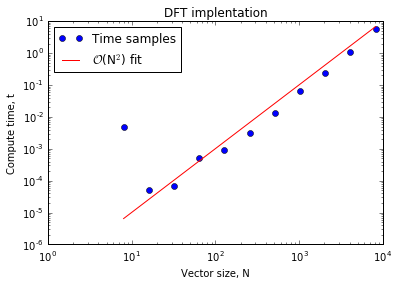

In [5]:
# First, we test the fit to a second order function in N
z = np.polyfit(N,t,2)
fit = [z[0]*np.power(n,2) for n in N]

plt.loglog(N,t,'bo',label="Time samples")
plt.loglog(N,fit,'r-',label=r"$\mathcal{O}$(N$^2$) fit")
plt.title('DFT implentation')
plt.xlabel('Vector size, N')
plt.ylabel('Compute time, t')
plt.legend(loc=0)
plt.show()

What is the largest vector that you can transform within a second?

In [6]:
# Use the scipy implementation of fsolve to solve for N when t=1s
def func(N):
    global z
    [a,b,c] = z
    t1 = 1
    return a*np.power(N,2)+b*N+c-t1
N_t1 = optimize.fsolve(func,1e4)

print('Longest vector we can transform in a second is: %s elements' % int(N_t1))
print('We can confirm this by testing a DFT on vector of length %s' % int(N_t1))
x = np.random.random(int(N_t1))
%timeit DFT(x)

Longest vector we can transform in a second is: 3804 elements
We can confirm this by testing a DFT on vector of length 3804
1 loops, best of 3: 897 ms per loop


The actual time to run a DFT of size N_t1 may be smaller than 1 due to changes in programs running in the background at various points. I typically found that the longest vector I could transform in a second was on the order of 4k elements.

## 02: FFT
Write a function that implements the fast Fourier transform algorithm. Show that, as a function of vector length, the computation scales as O(N log N) (You can also show it in log-log plot, but remember to plot a reference curve as N log N). What is the largest vector that you can transform within a second?

In [7]:
def FFT(y):
    N = len(y)
    
    # Allows us to catch the lowest-level recursion
    # Choose this based on the value of N at which DFT run time starts increasing linearly again
    if (N<=32):
        return DFT(y)
    # Runs the recursion over all other sizes N
    else:
        E = FFT(y[::2]) # get even-indexed values
        O = FFT(y[1::2]) # get odd-indexed values
        k = np.arange(N)
        C = np.exp(-2j*np.pi*k/N)
        # solve first and second halves
        Y = np.concatenate([E+C[:N/2]*O, E-C[N/2:]*O])
        return Y

In [8]:
N = N_range(2,13)
t = time_test(FFT,N,10)

/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


We see that $\mathcal{O}$(NlogN) scaling is a good fit for the data.

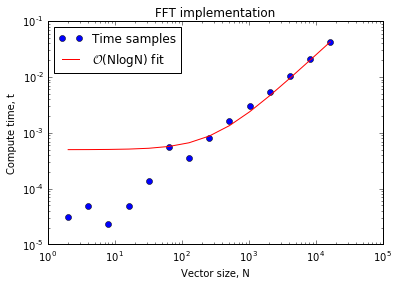

In [9]:
z = np.polyfit(N*np.log2(N),t,1)
fit = [z[0]*n*log2(n)+z[1] for n in N]

# Should be linear
plt.loglog(N,t,'bo',label="Time samples")
plt.loglog(N,fit,'r-',label=r"$\mathcal{O}$(NlogN) fit")
plt.title('FFT implementation')
plt.xlabel('Vector size, N')
plt.ylabel('Compute time, t')
plt.legend(loc=0)
plt.show()

In [10]:
# Use the scipy implementation of fsolve to solve for N when t=1s
def func(N):
    global z
    [a,b] = z
    t1 = 1 
    return N*np.log2(N) - (t1-b)/a
N_t1 = optimize.fsolve(func,1e4)
p = nearest_p2(N_t1)

print('Longest vector we can transform in a second is: %s elements' % int(N_t1))
print('We can confirm this by testing my FFT implementation on vector of length 2^%s' % int(p))
x = np.random.random(int(2**(p)))
%timeit FFT(x)

Longest vector we can transform in a second is: 298669 elements
We can confirm this by testing my FFT implementation on vector of length 2^18
1 loops, best of 3: 694 ms per loop


/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Because my FFT implementation only works for vectors that are of $2^m$ elements, I test the nearest power of 2 that is *less* than the calculated size of the longest vector I can transform in a second. If I tested my FFT implementation on a vector of size $2^{19}$, the time to run would be over 1s.

## 03: FFTW
Write a function that calls the built-in FFT interface (matlab), the scipy/numpy fftpack (Python), or the FFTW library for fast Fourier transforms (http://www.fftw.org/, C++ or Fortran).

Here, I use numpy's fft implementation to test the scaling of implemented packages.

In [11]:
N = N_range(2,20)
t = time_test(np.fft.fft,N,10)

Plotting crudely, it appears that there is some power law scaling at play, emergent at larger vector sizes.

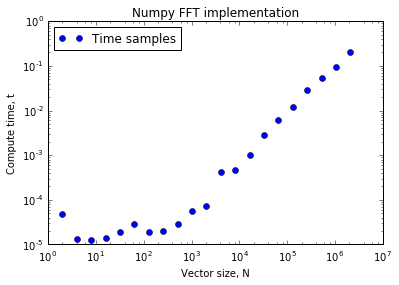

In [12]:
plt.loglog(N,t,'bo',label="Time samples")
plt.title('Numpy FFT implementation')
plt.xlabel('Vector size, N')
plt.ylabel('Compute time, t')
plt.legend(loc=2)
plt.show()

We can confirm this with a polyfit for $\mathcal{O}$(NlogN), seeing that the time points follow this fit particularly at longer time.

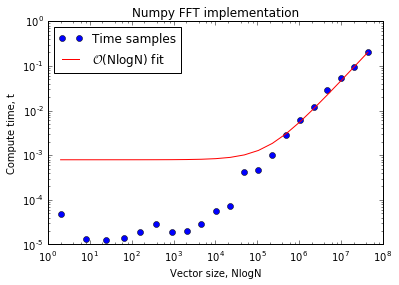

In [13]:
z = np.polyfit(N*np.log2(N),t,1)
fit = [z[0]*n*np.log2(n)+z[1] for n in N]

# Should be linear
plt.loglog(N*np.log2(N),t,'bo',label="Time samples")
plt.loglog(N*np.log2(N),fit,'r-',label=r'$\mathcal{O}$(NlogN) fit')
plt.title('Numpy FFT implementation')
plt.xlabel('Vector size, NlogN')
plt.ylabel('Compute time, t')
plt.legend(loc=0)
plt.show()

In [14]:
# Use the scipy implementation of fsolve to solve for N when t=1s
def func(N):
    global z
    [a,b] = z
    t1 = 1 
    return N*np.log2(N) - (t1-b)/a
N_t1 = optimize.fsolve(func,1e7)
p = nearest_p2(N_t1)

print('Longest vector we can transform in a second is: %s elements' % int(N_t1))
print('We can confirm this by testing np.fft on vector of length 2^%s' % int(p))
x = np.random.random(int(2**(p)))
%timeit np.fft.fft(x)

Longest vector we can transform in a second is: 9411452 elements
We can confirm this by testing np.fft on vector of length 2^23
1 loops, best of 3: 724 ms per loop
